In [155]:
import numpy as np
import pandas as pd

import string
import collections

# Кластеризация
from sklearn.cluster import KMeans

# уменьшение размерности
from sklearn.manifold import TSNE

# Алгоритм doc2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import doc2vec

# Токенизация предложений
from nltk import word_tokenize

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
# варнинг из пандаса
pd.options.mode.chained_assignment = None

In [2]:
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [144]:
def del_punc(s):
    """remove punctiation from string"""
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    return s

def load_data(path, columns, *, punc=True):
    """one keyword-only parameter: punc"""
    films = pd.read_csv(path)
    films_over = films[["id", columns]]
    
    if not punc:
        films_over["overview"] = films_over["overview"].apply(del_punc)
    
    return films_over

def get_tagged_documents(df, doc_column):
    """Should be "id" column"""
    tokenized_sent = [word_tokenize(doc) for doc in df[doc_column]]
    all_ids = df["id"].apply(lambda x: "id_" + str(x))
    
#     all_docs = list(zip(tokenized_sent, df["id"]))
    all_docs = list(zip(tokenized_sent, all_ids))
    
    tagged_documents = [TaggedDocument(words=doc[0], tags=[doc[1]]) for doc in all_docs]
    
    return tagged_documents

def doc_vectors(tagged_documents, ids):
    """train doc2ve model and return dataframe with document vectors with id"""
    model = doc2vec.Doc2Vec(tagged_documents, size = 50, min_count=3, window = 3, epochs=15)
    
    docs_vectors_with_id = pd.DataFrame(model.docvecs.vectors_docs, index = model.docvecs.doctags.keys())
    
    return docs_vectors_with_id, model

def kmeans_clustering(documents_vectors, n_clust):
    kmeans = KMeans(n_clusters = n_clust)
    kmeans.fit(document_vectors)
    
    return kmeans.labels_

def plot_optimal_clusters(document_vectors):
    """plots optimal number of clusters"""
    clust_num = range(1, 10)
    kmeans_models = [KMeans(n_clusters=i) for i in clust_num]
    score = [model.fit(document_vectors).score(document_vectors) for model in kmeans_models]
    
    plt.plot(clust_num, score)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score")
    plt.title("Elbow Curve")


def plot_tsne(document_vectors, clust_vector, p=30):
    tsne = TSNE(n_components=2, perplexity=p)
    tsne_df = tsne.fit_transform(document_vectors)
    tsne_df = pd.DataFrame(tsne_df, columns = ["x", "y"], index = document_vectors.index)
    tsne_df["clust"] = clust_vector
    
    sns.set(rc={"figure.figsize": (12, 8)})
    sns.lmplot("x", "y", data=tsne_df, hue="clust", fit_reg=False)
    return tsne_df

In [147]:
if __name__=="__main__":
    print("Loading data...")
    
    films = load_data("movie_info.csv", *["overview"], punc=False)
    ids_list = films["id"].tolist()
    
    print("Getting document vectors...")
    tagged_documents = get_tagged_documents(films, "overview")
   

    document_vectors, model = doc_vectors(tagged_documents, ids_list)

Loading data...
Getting document vectors...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
INFO : collecting all words and their counts
INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO : collected 15495 word types and 1867 unique tags from a corpus of 1867 examples and 97695 words
INFO : Loading a fresh vocabulary
INFO : min_count=3 retains 4518 unique words (29% of original 15495, drops 10977)
INFO : min_count=3 leaves 84173 word corpus (86% of original 97695, drops 13522)
INFO : deleting the raw counts dictionary of 15495 items
INFO : sample=0.001 downsamples 37 most-common words
INFO : downsampling leaves estimated 61814 word corpus (73.4% of prior 84173)
INFO : estimated required memory for 4518 words and 50 dimensions: 48130

In [191]:
tagged_documents[0].tags[0]

'id_3'

In [200]:
ranks = []
for doc in tagged_documents:
    inferred_vector = model.infer_vector(doc.words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
#     print(sims)
    rank = [docid for docid, sim in sims].index(doc.tags[0])
    ranks.append(rank)

In [198]:
collections.Counter(ranks).most_common()[:5]

[(30, 5), (1171, 5), (642, 5), (493, 5), (1198, 5)]

In [151]:
clust_vector = kmeans_clustering(document_vectors, 4)

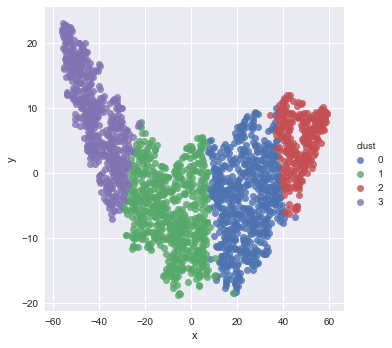

In [154]:
tsne_df = plot_tsne(document_vectors, clust_vector, 60)

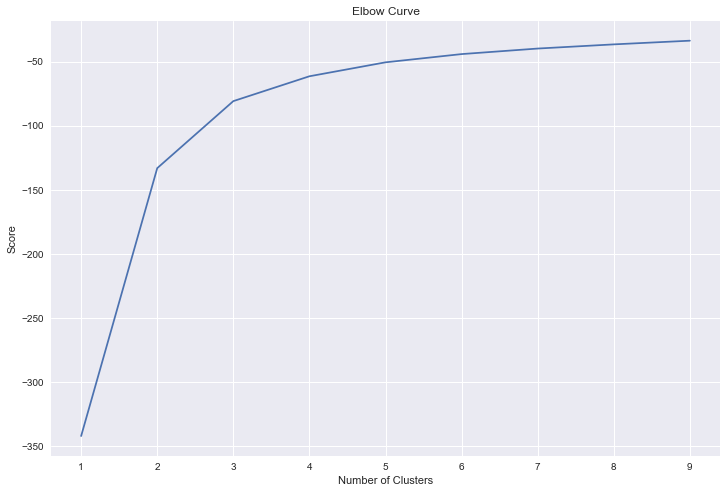

In [149]:
clust_doc_vectors(document_vectors)